In [1]:
from functools import partial

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar

from models.data import JSRTDataModule, CheXpertDataModule, CLEVRNDataset, LIDCDataModule
from models.mae.mae import ViTAE
from models.encoders import CNNEncoder
from models.segmentation import ObjectSpecificSegmentation

from pytorch_lightning.loggers import WandbLogger
from pathlib import Path

In [2]:
cnnencoder = CNNEncoder(slot_dim=128, num_channels=1)

In [3]:
#saved_model.eval()
oss = ObjectSpecificSegmentation(cnnencoder, num_slots=2, num_iterations=3, num_classes=2, slot_dim=128, task='recon', decoder_type='shared', 
                                 learning_rate=4e-4, freeze_encoder=False, temperature=1, log_images=False, lr_warmup=True, include_seg_loss=True,
                                 softmax_class=True, slot_attn_type='mulit-head', image_chans=1, embedding_dim=128, image_resolution=128)

# oss = ObjectSpecificSegmentation.load_from_checkpoint('/vol/bitbucket/bc1623/project/semi_supervised_uncertainty/runs/lightning_logs/obj_centric_chest_seg/obj_centric_chest_seg/hbhw4siv/checkpoints/epoch=3-step=1323.ckpt',
    # saved_model, num_slots=4, num_iterations=3, num_classes=4, slot_dim=768, task='recon', decoder_type='shared', 
    #                              learning_rate=1e-4, freeze_encoder=True, temperature=5, log_images=True, lr_warmup=False, include_seg_loss=False,
    #                              softmax_class=False, slot_attn_type='mulit-head', image_chans=1)

In [5]:
#data = CLEVRNDataset(batch_size=32)
#data = JSRTDataModule(data_dir='./data/JSRT/', batch_size=64, augmentation=True)
#data = CheXpertDataModule(data_dir='/vol/biodata/data/chest_xray/CheXpert-v1.0/preproc_224x224/', batch_size=256, cache=False)
data = LIDCDataModule(batch_size=256)

Text(0.5, 1.0, 'segmentation')

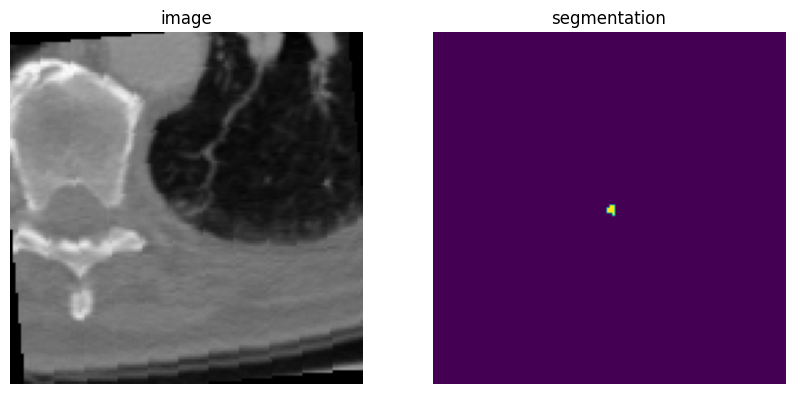

In [6]:
import matplotlib.pyplot as plt
import matplotlib

batch = next(iter(data.train_dataloader()))
image = batch['image'][0].cpu().numpy().squeeze()
labelmap = batch['labelmap'][0][0].cpu().numpy().squeeze()
f, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image, cmap=matplotlib.cm.gray)
ax[0].axis('off')
ax[0].set_title('image')

ax[1].imshow(labelmap, cmap='viridis')
ax[1].axis('off')
ax[1].set_title('segmentation')



In [7]:
#oss.include_seg_loss = True
# freeze oss decoder
#oss.decoder.requires_grad_(False)

In [9]:
# from pytorch_lightning.loggers import WandbLogger
# wandb_logger = WandbLogger(save_dir='./runs/lightning_logs/obj_centric_chest_seg/', project='obj_centric_chest_seg',
#                            name='multi_proj_test')
# output_dir = Path(f"obj_centric_chest_seg/run_{wandb_logger.experiment.id}")  # type: ignore
# print("Saving to" + str(output_dir.absolute()))

trainer = Trainer(
    max_epochs=2500,
    precision='16-mixed',
    accelerator='auto',
    devices=[0],
    #strategy='ddp_notebook',
    # log_every_n_steps=250,
    #val_check_interval=0.5,
    check_val_every_n_epoch=5,
    # #save_top_k=1,
    #logger=wandb_logger,
    # callbacks=[ModelCheckpoint(monitor="val_loss", mode='min'), TQDMProgressBar(refresh_rate=100)],
)
torch.set_float32_matmul_precision('medium')

trainer.fit(model=oss, datamodule=data)

# trainer.validate(model=oss, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

# trainer.test(model=oss, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name                   | Type                        | Params
-----------------------------------------------------------------------
0 | encoder                | CNNEncoder                  | 442 K 
1 | encoder_pos_embeddings | SoftPositionEmbed           | 640   
2 | slot_attention         | FixedSlotAttentionMultiHead | 248 K 
3 | decoder                | SlotSpecificDecoder         | 2.2 M 
4 | decoder_pos_embeddings | SoftPositionEmbed           | 640   
5 | embedding_norm         | LayerNorm                   | 256   
6 | mlp                    | Sequential                  | 65.9 K
-----------------------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.691

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

: 

In [ ]:
image_num = 0
batch = next(iter(data.test_dataloader()))
# vertical flip batch
# batch['image'] = torch.flip(batch['image'], [2])
# batch['labelmap'] = torch.flip(batch['labelmap'], [2])

batch['image'] = batch['image'][:2]
batch['labelmap'] = batch['labelmap'][:2]
# move to gpu
# batch = {k: v.to(cuda_device) for k, v in batch.items()}
# oss.to(cuda_device)

with torch.no_grad():
    loss, dsc, probs, preds, _ = oss.process_batch(batch, 1)
image = batch['image'][image_num].squeeze()
labelmap = batch['labelmap'][image_num].squeeze()
probmap = torch.max(probs.cpu(), dim=1, keepdim=True)[0].squeeze().detach().numpy()
predmap = preds[image_num].squeeze()

f, ax = plt.subplots(1,4, figsize=(15, 15))

ax[0].imshow(image, cmap=matplotlib.cm.gray)
ax[0].axis('off')
ax[0].set_title('image')

ax[1].imshow(labelmap, cmap=matplotlib.cm.gray)
ax[1].axis('off')
ax[1].set_title('labelmap')

ax[2].imshow(predmap, cmap=matplotlib.cm.gray)
ax[2].axis('off')
ax[2].set_title('prediction')

ax[3].imshow(probmap[image_num, ...], cmap='plasma')
ax[3].axis('off')
ax[3].set_title('probability map')

image_num += 1
image = batch['image'][image_num].squeeze()
labelmap = batch['labelmap'][image_num].squeeze()
probmap = torch.max(probs.cpu(), dim=1, keepdim=True)[0].squeeze().detach().numpy()
predmap = preds[image_num].squeeze()

f, ax = plt.subplots(1,4, figsize=(15, 15))

ax[0].imshow(image, cmap=matplotlib.cm.gray)
ax[0].axis('off')
ax[0].set_title('image')

ax[1].imshow(labelmap, cmap=matplotlib.cm.gray)
ax[1].axis('off')
ax[1].set_title('labelmap')

ax[2].imshow(predmap, cmap=matplotlib.cm.gray)
ax[2].axis('off')
ax[2].set_title('prediction')

ax[3].imshow(probmap[image_num, ...], cmap='plasma')
ax[3].axis('off')
ax[3].set_title('probability map')

In [ ]:
# plot attention matrix
image_num = 0
attn = oss.attn[image_num].cpu().detach().numpy()   
# slot 0
# slot_0_attn = attn[0, :]
# slot_0_attn = slot_0_attn.reshape(14, 14)

f, ax = plt.subplots(1, attn.shape[0], figsize=(15, 15))

for slot in range(attn.shape[0]):
    slot_attn = attn[slot, :]
    slot_attn = slot_attn.reshape(14, 14)
    ax[slot].imshow(slot_attn, cmap=matplotlib.cm.gray)
    ax[slot].axis('off')
    ax[slot].set_title(f'slot {slot}')

In [ ]:
# calculate entropy of predictions
image_num = 0
trials = 5
batch = next(iter(data.test_dataloader()))

list_entropy = []
#all_preds = torch.empty((batch['image'].shape[0], 224, 224), dtype=torch.long)
oss.to(cuda_device)
batch = {k: v.to(cuda_device) for k, v in batch.items()}
for _ in range(trials):
    with torch.no_grad():
        loss, dsc, probs, preds, _ = oss.process_batch(batch)
        list_entropy.append(preds)

all_preds = torch.stack(list_entropy, dim=1)
oss.to('cpu')
del batch
print(all_preds.shape)

In [ ]:
def calculate_class_entropy(predictions):
    """
    Calculate entropy of class predictions for each pixel.
    
    Args:
    predictions: Tensor of shape (N, H, W) where N is the number of predictions,
                 H and W are height and width. Values are class indices.
    
    Returns:
    entropy: Tensor of shape (H, W) containing entropy for each pixel
    """
    N, H, W = predictions.shape
    num_classes = predictions.max().item() + 1  # Assuming class indices start from 0
    
    # Create one-hot encoding
    one_hot = torch.zeros(N, num_classes, H, W, device=predictions.device)
    one_hot.scatter_(1, predictions.unsqueeze(1), 1)
    
    # Sum over the N dimension to get class counts
    class_counts = one_hot.sum(dim=0)  # Shape: (num_classes, H, W)
    
    # Calculate probabilities
    probabilities = class_counts / N
    
    # Add a small epsilon to avoid log(0)
    epsilon = 1e-7
    probabilities = torch.clamp(probabilities, epsilon, 1 - epsilon)
    
    # Calculate entropy
    entropy = -torch.sum(probabilities * torch.log2(probabilities), dim=0)
    
    return entropy

# Example usage
# Assuming 'stacked_predictions' is your tensor of shape (N, H, W)
image_num = 7
pixel_entropy = calculate_class_entropy(all_preds[image_num, ...]).cpu()

f, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.imshow(pixel_entropy, cmap='plasma')
ax.axis('off')
ax.set_title('image')